# Building convolutional neural networks in Tensorflow and Keras

# Convolutional neural networks
  
Convolutional neural networks are neural networks built from the assumption that the inputs
to the network are 2D images. This is important because the number of features or pixels in images
grows very fast with the image size, and an enormous number of weights and biases are needed in order to build an accurate network.  
  
As before, we still have our input, a hidden layer and an output. What's novel about convolutional networks
are the **convolutional** and **pooling** layers stacked in pairs between the input and the hidden layer.
In addition, the data is no longer represented as a 2D feature matrix, instead each input is a number of 2D
matrices, typically 1 for each color dimension (Red, Green, Blue). This means that to represent the entire
dataset of images, we require a 4D matrix or **tensor**. This tensor has the dimensions:  
  
$$ (n_{inputs},\, n_{pixels, width},\, n_{pixels, height},\, depth) .$$  
  
The MNIST dataset consists of grayscale images with a pixel size of 28x28, meaning we require $28 \times 28 = 724$
weights to each neuron in the first hidden layer. If we were to analyze images of size 128x128 we would require
$128 \times 128 = 16384$ weights to each neuron. Even worse if we were dealing with color images, as most images are,
we have an image matrix of size 128x128 for each color dimension (Red, Green, Blue), meaning 3 times the number of weights $= 49152$ are required for every single neuron in the first hidden layer.  
  
Images typically have strong local correlations, meaning that a small part of the image varies little from its neighboring regions. If for example we have an image of a blue car, we can roughly assume that a small blue part of the image is surrounded by other blue regions.
Therefore, instead of connecting every single pixel to a neuron in the first hidden layer, as we have previously done
with deep neural networks, we can instead connect each neuron to a small part of the image (in all 3 RGB depth dimensions).  
The size of each small area is fixed, and known as a [receptive field](https://en.wikipedia.org/wiki/Receptive_field).  
  
The layers of a convolutional neural network arrange neurons in 3 dimensions: width, height and depth.  
The input image is typically a square matrix of depth 3. A **convolution** is performed on the image which outputs
a 3D volume of neurons. The weights to the input are arranged in a number of 2D matrices, known as **filters**.
Each filter slides along the input image, taking the dot product between each small part of the image and the filter, in all depth dimensions. This is then passed through a non-linear function, typically the Rectified Linear (ReLu) function, which serves as the activation of the neurons in the first convolutional layer. This is then passed
through a pooling layer, which reduces the size of the convolutional layer, e.g. by taking the maximum or average across some small regions, and this serves as input to the next convolutional layer.  
  
By systematically reducing the size of the input volume, through convolution and pooling, the network should
create representations of small parts of the input, and then from them assemble representations of larger areas.  
The final pooling layer is flattened to serve as input to a hidden layer, where each neuron in the hidden layer
is connected to every single neuron in the final pooling layer. This then serves as input to the output layer, e.g. a softmax output for classification.  
  
For more information, you are highly encouraged to check out the webpages for the excellent course  
[CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/),  
which is taught at Stanford University (consistently ranked as one of the top computer science programs in the world).  
In particular, you can find the lecture on convolutional neural networks [here](http://cs231n.github.io/convolutional-networks/).

![CNN](https://res.mdpi.com/entropy/entropy-19-00242/article_deploy/html/images/entropy-19-00242-g001.png)
Via [Entropy](http://www.mdpi.com/1099-4300/19/6/242)

# Prerequisites
  
This guide builds on the guide to building neural networks in Tensorflow and Keras,
and it is recommended you start there.

# 1) Collect and pre-process data

inputs = (n_inputs, pixel_width, pixel_height, depth) = (1797, 8, 8, 1)
labels = (n_inputs) = (1797,)


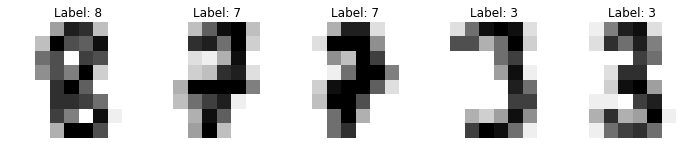

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

# RGB images have a depth of 3
# our images are grayscale so they should have a depth of 1
inputs = inputs[:,:,:,np.newaxis]

print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# choose some random images to display
n_inputs = len(inputs)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()


In [2]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# onehot representation of labels
labels = to_categorical(labels)

# split into train and test data
# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)


Using TensorFlow backend.


# 2) Define model and architecture
# 3) Choose cost function and optimizer

In [3]:
import tensorflow as tf

class ConvolutionalNeuralNetworkTensorflow:
    def __init__(
        self,
        X_train,
        Y_train,
        X_test,
        Y_test,
        n_filters=10,
        n_neurons_connected=50,
        n_categories=10,
        receptive_field=3,
        stride=1,
        padding=1,
        epochs=10,
        batch_size=100,
        eta=0.1,
        lmbd=0.0,
    ):
        
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
        self.n_inputs, self.input_width, self.input_height, self.depth = X_train.shape
        
        self.n_filters = n_filters
        self.n_downsampled = int(self.input_width*self.input_height*n_filters / 4)
        self.n_neurons_connected = n_neurons_connected
        self.n_categories = n_categories
        
        self.receptive_field = receptive_field
        self.stride = stride
        self.strides = [stride, stride, stride, stride]
        self.padding = padding
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        self.create_placeholders()
        self.create_CNN()
        self.create_loss()
        self.create_optimiser()
        self.create_accuracy()
    
    def create_placeholders(self):
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, shape=(None, self.input_width, self.input_height, self.depth), name='X_data')
            self.Y = tf.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_CNN(self):
        with tf.name_scope('CNN'):
            
            # Convolutional layer
            self.W_conv = self.weight_variable([self.receptive_field, self.receptive_field, self.depth, self.n_filters], name='conv', dtype=tf.float32)
            b_conv = self.weight_variable([self.n_filters], name='conv', dtype=tf.float32)
            z_conv = tf.nn.conv2d(self.X, self.W_conv, self.strides, padding='SAME', name='conv') + b_conv
            a_conv = tf.nn.relu(z_conv)
            
            # 2x2 max pooling
            a_pool = tf.nn.max_pool(a_conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME', name='pool')
            
            # Fully connected layer
            a_pool_flat = tf.reshape(a_pool, [-1, self.n_downsampled])
            self.W_fc = self.weight_variable([self.n_downsampled, self.n_neurons_connected], name='fc', dtype=tf.float32)
            b_fc = self.bias_variable([self.n_neurons_connected], name='fc', dtype=tf.float32)
            a_fc = tf.nn.relu(tf.matmul(a_pool_flat, self.W_fc) + b_fc)
            
            # Output layer
            self.W_out = self.weight_variable([self.n_neurons_connected, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc, self.W_out) + b_out
    
    def create_loss(self):
        with tf.name_scope('loss'):
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.Y, logits=self.z_out))
            
            regularizer_loss_conv = tf.nn.l2_loss(self.W_conv)
            regularizer_loss_fc = tf.nn.l2_loss(self.W_fc)
            regularizer_loss_out = tf.nn.l2_loss(self.W_out)
            regularizer_loss = self.lmbd*(regularizer_loss_conv + regularizer_loss_fc + regularizer_loss_out)
            
            self.loss = softmax_loss + regularizer_loss

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            probabilities = tf.nn.softmax(self.z_out)
            predictions = tf.argmax(probabilities, 1)
            labels = tf.argmax(self.Y, 1)
            
            correct_predictions = tf.equal(predictions, labels)
            correct_predictions = tf.cast(correct_predictions, tf.float32)
            self.accuracy = tf.reduce_mean(correct_predictions)
    
    def create_optimiser(self):
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)

    def fit(self):
        data_indices = np.arange(self.n_inputs)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epochs):
                for j in range(self.iterations):
                    chosen_datapoints = np.random.choice(data_indices, size=self.batch_size, replace=False)
                    batch_X, batch_Y = self.X_train[chosen_datapoints], self.Y_train[chosen_datapoints]
            
                    sess.run([CNN.loss, CNN.optimizer],
                        feed_dict={CNN.X: batch_X,
                                   CNN.Y: batch_Y})
                    accuracy = sess.run(CNN.accuracy,
                        feed_dict={CNN.X: batch_X,
                                   CNN.Y: batch_Y})
                    step = sess.run(CNN.global_step)
    
            self.train_loss, self.train_accuracy = sess.run([CNN.loss, CNN.accuracy],
                feed_dict={CNN.X: self.X_train,
                           CNN.Y: self.Y_train})
        
            self.test_loss, self.test_accuracy = sess.run([CNN.loss, CNN.accuracy],
                feed_dict={CNN.X: self.X_test,
                           CNN.Y: self.Y_test})

# 4) Train the model
# 5) Evaluate model performance on test data
# 6) Adjust hyperparameters (if necessary, network architecture)

In [5]:
epochs = 100
batch_size = 100
n_filters = 10
n_neurons_connected = 50
n_categories = 10

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)


In [6]:
CNN_tf = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = ConvolutionalNeuralNetworkTensorflow(X_train, Y_train, X_test, Y_test,
                                      n_filters=n_filters, n_neurons_connected=n_neurons_connected,
                                      n_categories=n_categories, epochs=epochs, batch_size=batch_size,
                                      eta=eta, lmbd=lmbd)
        CNN.fit()
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % CNN.test_accuracy)
        print()
            
        CNN_tf[i][j] = CNN

Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.122

Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.181

Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.144

Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.094

Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.094

Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.131

Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.103

Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.289

Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 0.389

Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 0.375

Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 0.314

Learning rate =  0.0001
Lambda =  0.1
Test accuracy: 0.275

Learning rate =  0.0001
Lambda =  1.0
Test accuracy: 0.375

Learning rate =  0.0001
Lambda =  10.0
Test accuracy: 0.128

Learning rate =  0.001
Lambda =  1e-05
Test accuracy: 0.903

Learning rate =  0.001
Lambda =  0.0001
Test accuracy: 0.886

Learning rate =  0.001
Lam

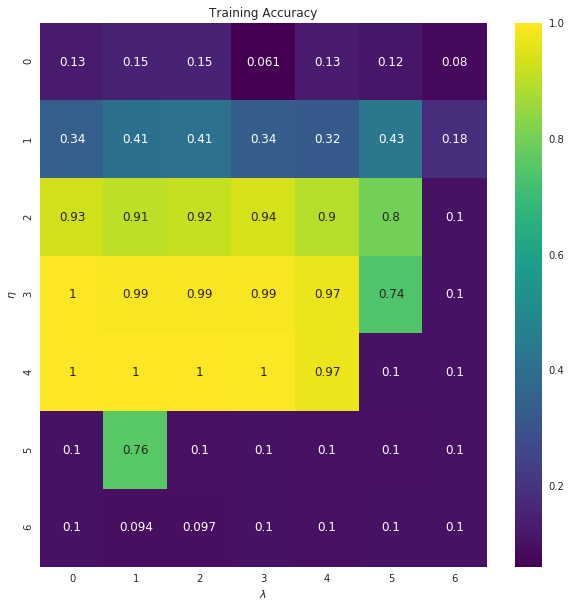

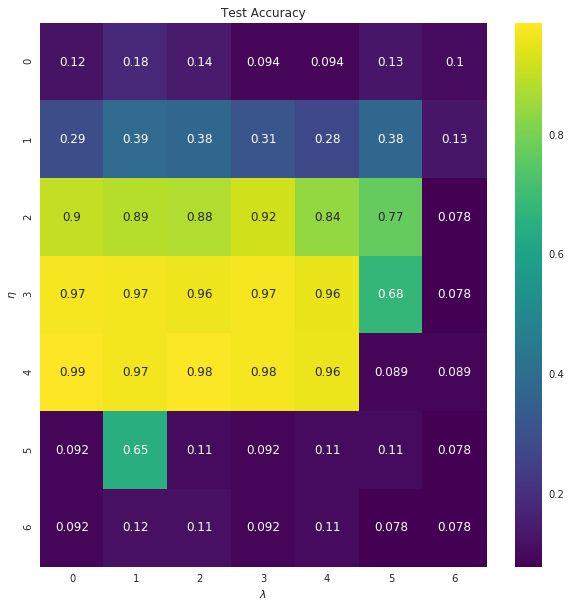

In [7]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_tf[i][j]

        train_accuracy[i][j] = CNN.train_accuracy
        test_accuracy[i][j] = CNN.test_accuracy

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()


In [8]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import SGD

def create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd):
    model = Sequential()
    model.add(Conv2D(n_filters, (receptive_field, receptive_field), input_shape=input_shape, padding='same',
              activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(n_neurons_connected, activation='relu', kernel_regularizer=l2(lmbd)))
    model.add(Dense(n_categories, activation='softmax'))
    
    sgd = SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model


In [9]:
epochs = 100
batch_size = 100
input_shape = X_train.shape[1:4]
receptive_field = 3
n_filters = 10
n_neurons_connected = 50
n_categories = 10

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)

In [10]:
CNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd)
        CNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = CNN.evaluate(X_test, Y_test)
        
        CNN_keras[i][j] = CNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()
        

360/360 [==============================] - 0s 614us/step
Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.200

360/360 [==============================] - 0s 571us/step
Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.197

360/360 [==============================] - 0s 603us/step
Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.225

360/360 [==============================] - 0s 607us/step
Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.172

360/360 [==============================] - 0s 739us/step
Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.156

360/360 [==============================] - 0s 651us/step
Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.192

360/360 [==============================] - 0s 689us/step
Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.142

360/360 [==============================] - 0s 690us/step
Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.411

360/360 [==============================] - 0s 745us/step
Lea

360/360 [==============================] - 0s 64us/step


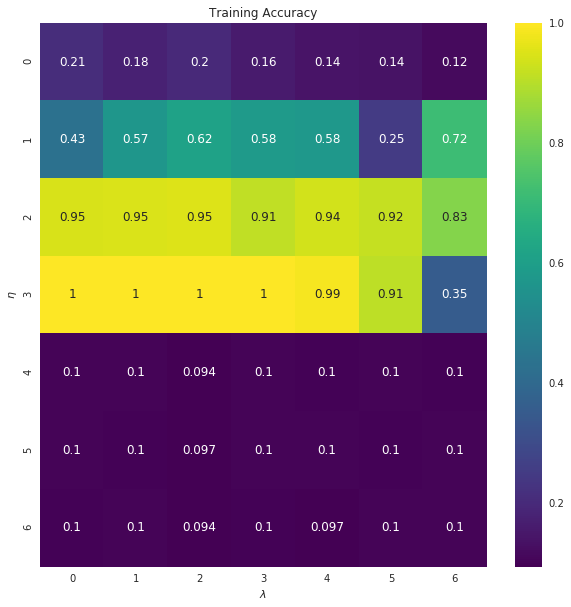

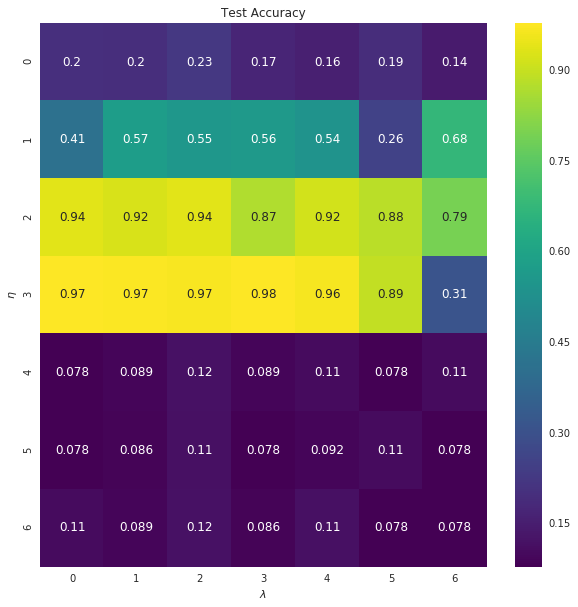

In [11]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_keras[i][j]

        train_accuracy[i][j] = CNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = CNN.evaluate(X_test, Y_test)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()


# Appendix

# Fun links
  
1) [Self-Driving cars using a convolutional neural network](https://arxiv.org/abs/1604.07316)  
2) [Abstract art using convolutional neural networks](https://deepdreamgenerator.com/)